In [1]:
# If you want change predictor, change predictors below


# Code part 0, config

#[Note: recipe(target ~ ., data = heart_data_train)
# predictors <- c("age", "trestbps", "chol")
# predictors <- c("age", "trestbps", "chol", "thalach")
predictors <- c("age", "thalach")
# Example: predictors <- c("age", "chol") == 
#          recipe(num ~ age+chol, data = heart_data_train)
# predictors: all predictors

# Remember: change K at Code part 5


# Config - part 6, result visualizing, x_var: x-axis variable name, y_var: y-axis
# If Kernel error, try less dots
enablePart6 <- TRUE
dots <- 50 # suggest 100
# x_var <- "age"
# y_var <- "chol"

x_var <- "age"
y_var <- "thalach"


target <- "num"

default_plot_width <- 8
default_plot_height <- 8

set.seed(1)

HumanReadableMappingTable <- 
    data.frame(raw_col=rep(c("age", "trestbps", "chol", "thalach", "num")),
    readable=rep(c("age_readable", "trestbps_readable", "chol_readable", "thalach_readable", "num_readable"))
    #, readable_short=rep(c("age_readable", "trestbps_readable", "chol_readable", "thalach_readable", "num_readable"))
          )

# ----------------------------------END CONFIG---------------------------
# make x_var, y_var in predictors
if(enablePart6 & !(x_var %in% predictors)){
    stop("x_var not in predictors")
}
if(enablePart6 & !(y_var %in% predictors)){
    stop("y_var not in predictors")
}


HumanReadable <- function(colName){
  readable <- HumanReadableMappingTable %>% 
    filter(raw_col == all_of(colName)) %>% 
    select(readable)
  if (dim(readable)[1] == 0) {
    return(colName)
  } else{
    return(readable %>% pull())
  }
}

HumanReadableShort <- function(colName){
  if (!("readable_short" %in% HumanReadableMappingTable)){return(sprintf("%s_short", HumanReadable(colName)))}
  readable_s <- HumanReadableMappingTable %>% 
    filter(raw_col == all_of(colName)) %>% 
    select(readable_short)
  if (dim(readable_s)[1] == 0) {
    return(sprintf("%s_short", HumanReadable(colName)))
  } else{
    return(readable_s %>% pull())
  }
}


In [2]:
# Code part 1, load lib, read data, wrangle data, split data.

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
library(GGally)
library(cowplot)
options(repr.matrix.max.rows = 10)
options(repr.plot.width = default_plot_width, repr.plot.height = default_plot_height)

heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_data <- read_csv(heart_disease_url, col_names = col_names) %>%
    map_df(as.double) %>%
    mutate(num=case_when(num == 0 ~ 0, TRUE ~ 1)) %>%
    mutate(cp=case_when(cp == 1 ~ 2, TRUE ~ cp)) %>%

    mutate(target=as.factor(get(target))) %>%
    select(all_of(append(predictors, "target"))) %>%
    na.omit()
names(heart_data)[names(heart_data) == "target"] <- target

df_split <- initial_split(heart_data, prop = 0.75, strata = all_of(target))
heart_data_train <- training(df_split)
heart_data_test <- testing(df_split)

heart_data_train

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

age,thalach,num
<dbl>,<dbl>,<fct>
63,150,0
67,108,1
67,129,1
37,187,0
41,172,0
⋮,⋮,⋮
63,144,1
41,182,0
57,123,1


[1] "Total observations: 228"


`summarise()` ungrouping output (override with `.groups` argument)



num,count
<fct>,<int>
0,123
1,105


[1] "Mean of: age_readable_short is: 54.20"
[1] "Mean of: thalach_readable_short is: 149.77"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



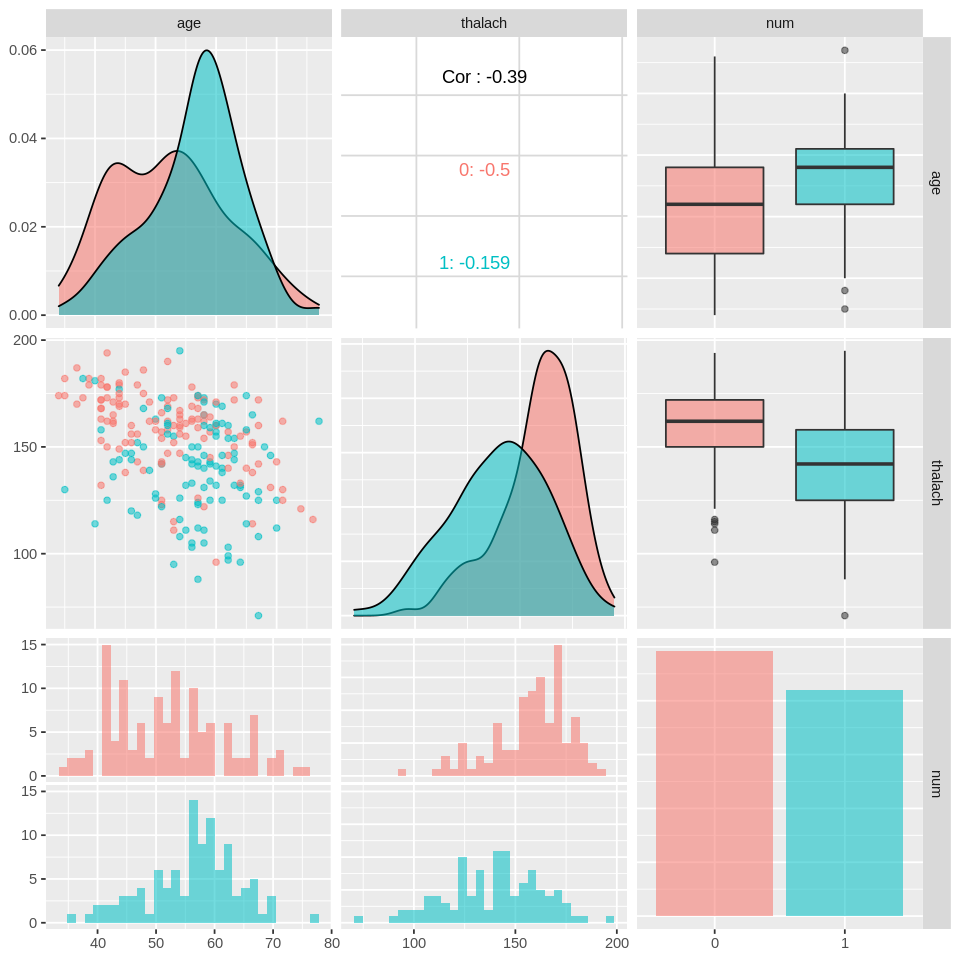

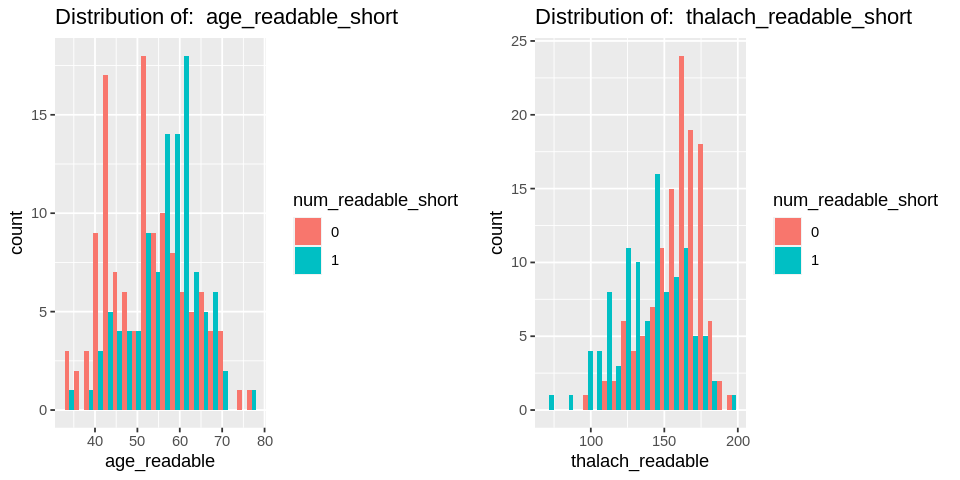

In [14]:
# Code part 2, Visualizing, Summarize data before analyzing.
count_num <- group_by(heart_data_train) %>%
            summarize(count = n()) %>%
            pull()
print(paste("Total observations:", count_num))
summarize_by_target <- heart_data_train %>% 
    group_by(get(target)) %>%
    summarize(count = n())
names(summarize_by_target)[names(summarize_by_target) == "get(target)"] <- target
summarize_by_target
for (i in predictors){
    means <- map_df(heart_data_train %>% select(all_of(i)), mean) %>% pull()
    sds <- map_df(heart_data_train %>% select(all_of(i)), sd) %>% pull()
    print(sprintf("Mean of: %s is: %.2f", HumanReadableShort(i), means))
    # print(sprintf("Standard deviation of: %s is: %.2f", HumanReadableShort(i), sds))
}

ggpairs(heart_data_train,
  mapping=aes(colour = get(target), alpha=0.4))

histogramPlot <- function(p){
  ggplot(heart_data_train, aes(x=get(p), fill = get(target))) +
    geom_histogram(bins=20, position = "dodge") +
    labs(x=HumanReadable(p), fill=HumanReadableShort(target)) +
    ggtitle(paste("Distribution of: ", HumanReadableShort(p)))
}

options(repr.plot.width = default_plot_width, repr.plot.height = (default_plot_height/2) * ceiling(length(predictors)/2))
plot_grid(plotlist = map(predictors, histogramPlot), ncol = 2)
options(repr.plot.width = default_plot_width, repr.plot.height = default_plot_height)

In [4]:
# Code part 3, Classification, tuning
heart_recipe <- recipe(as.formula(paste(target, "~ .")), data = heart_data_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_vfold <- vfold_cv(heart_data_train, v = 5, strata = all_of(target))
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = heart_vfold, grid = gridvals) %>%
  collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7322705,5,0.04272793,Model15
16,accuracy,binary,0.7322705,5,0.04272793,Model16
13,accuracy,binary,0.7279227,5,0.04423322,Model13
9,accuracy,binary,0.7237681,5,0.05475764,Model09
10,accuracy,binary,0.7237681,5,0.05475764,Model10
14,accuracy,binary,0.7235749,5,0.04470320,Model14


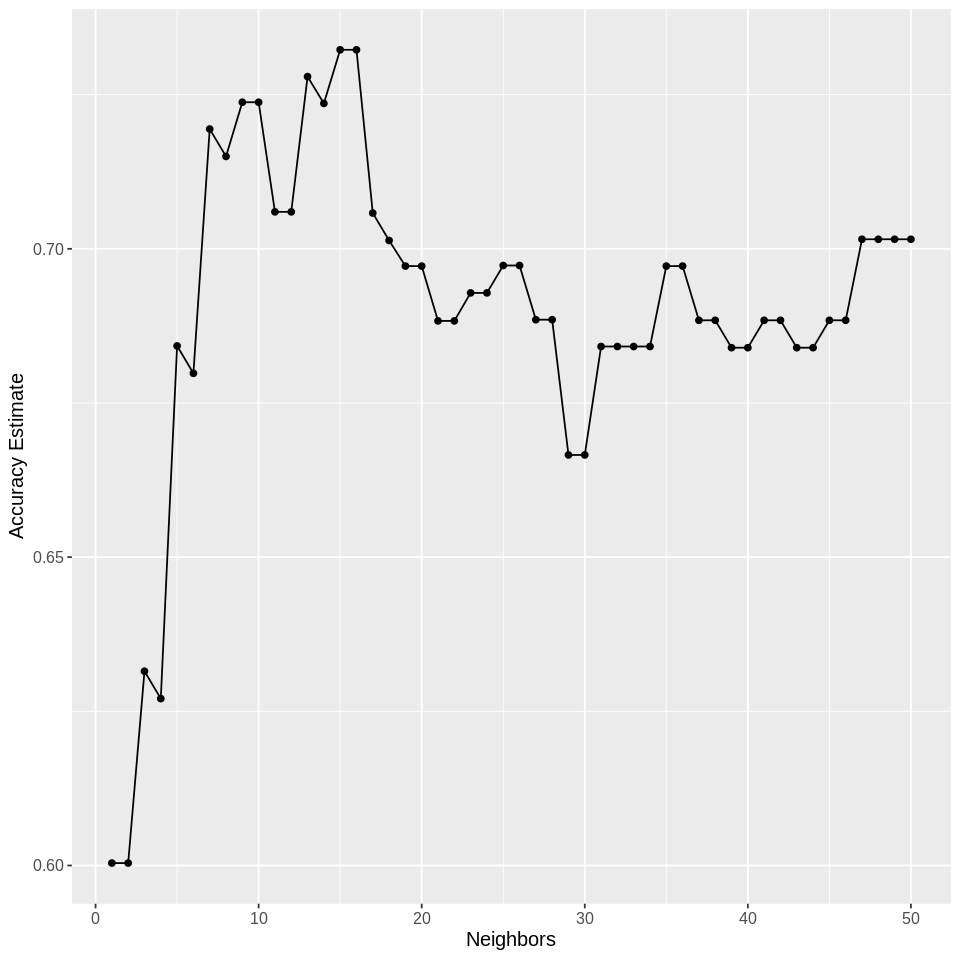

In [5]:
# Code part 4, analysis result from tuning
accuracies <- knn_results %>%
  filter(.metric == "accuracy") %>% 
  arrange(desc(mean))
head(accuracies , 6)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k
# best_k <- slice(accuracies, 1) %>% 
#   select(neighbors) %>% 
#   pull()

# print(paste("Best k value:", best_k))

In [6]:
# change k based on the graph.
best_k <- 15

# Code part 5, use best_k to fit
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_fit <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec2) %>%
  fit(heart_data_train)

heart_predict <- predict(heart_fit, heart_data_test) %>%
  bind_cols(heart_data_test) 

heart_predict_accuracy <- heart_predict %>%
  metrics(truth = all_of(target), estimate = .pred_class) %>%
  filter(.metric == "accuracy") %>%
  select(.estimate) %>%
  pull()

confusion <- heart_predict %>%
             conf_mat(truth = all_of(target), estimate = .pred_class)

print(paste("Predict Accuracy:", heart_predict_accuracy))
print("confusion: ")
confusion

[1] "Predict Accuracy: 0.733333333333333"
[1] "confusion: "


          Truth
Prediction  0  1
         0 30  9
         1 11 25

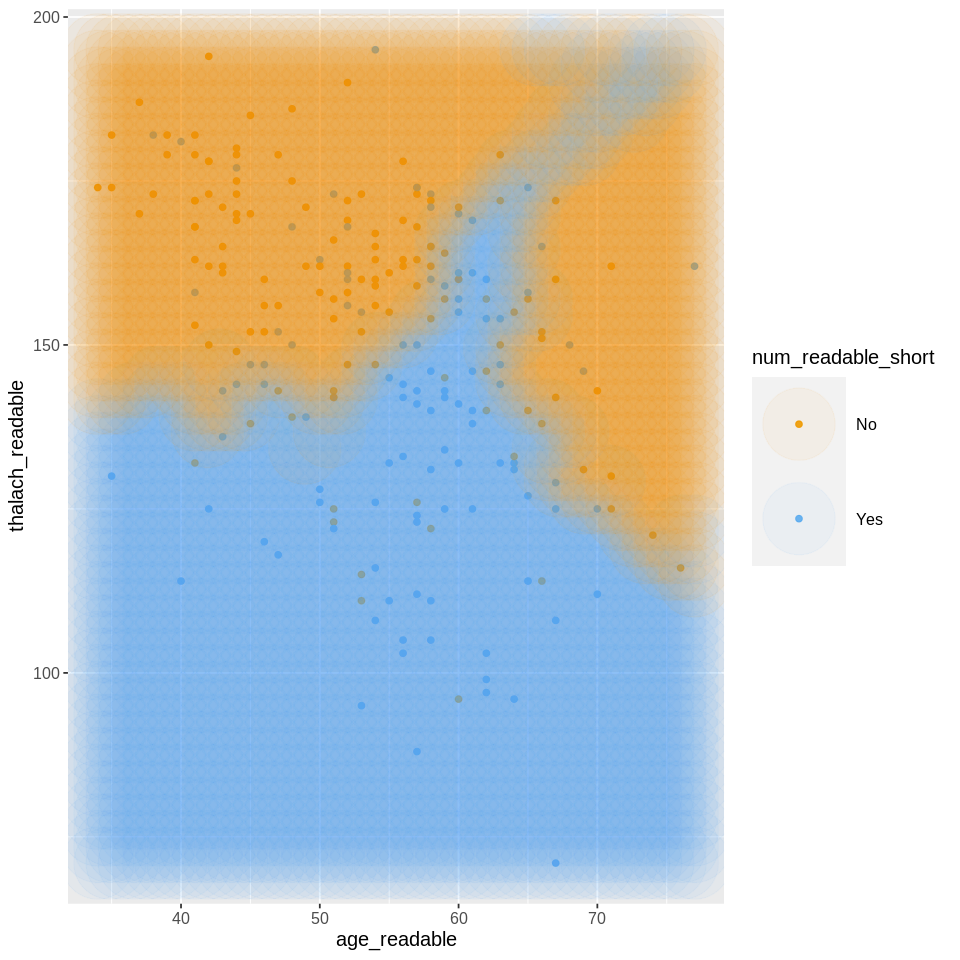

In [7]:
# Code part 6, result visualizing
# Note: some code copyed from textbook 5.8

if (enablePart6){

# x <- heart_data_train[1]
x <- heart_data_train %>% select(all_of(x_var))
# y <- heart_data_train[2]
y <- heart_data_train %>% select(all_of(y_var))

others <- heart_data_train %>% 
    select(-colnames(x), -colnames(y), -all_of(target))  %>% 
    map_df(mean)

x_grid <- seq(min(x), max(x), length.out = dots)
y_grid <- seq(min(y), max(y), length.out = dots)

asgrid <- as_tibble(expand.grid(x = x_grid, y = y_grid)) 
if (!is_empty(others)){
    asgrid <- merge(asgrid, others)
}
names(asgrid)[names(asgrid) == "x"] <- colnames(x)
names(asgrid)[names(asgrid) == "y"] <- colnames(y)

knnPredGrid <- predict(heart_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) #%>% rename(num = .pred_class)
names(prediction_table)[names(prediction_table) == ".pred_class"] <- target

wkflw_plot <- ggplot() +
  geom_point(data = heart_data_train, 
             mapping = aes(x = get(colnames(x)), 
                           y = get(colnames(y)), 
                           color = get(target)), 
             alpha = 0.9) +
  geom_point(data = prediction_table, 
             mapping = aes(x = get(colnames(x)), 
                           y = get(colnames(y)), 
                           color = get(target)), 
             alpha =  2.5 / dots, 
             size = 1000 / dots) +
  labs(color = HumanReadableShort(target), # "heart disease?"
       x = HumanReadable(x_var),
       y = HumanReadable(y_var)
      ) +
  scale_color_manual(labels = c("0" = "No", "1" = "Yes"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot
}